In [1]:
import pandas as pd
from framework.datasource import CSVDataSource
from framework.cleaner    import Cleaner
from framework.model.classification import LogisticClassification
from framework.model.regression     import LinearRegressionModel
from framework.model.clustering     import KMeansClustering
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
src = CSVDataSource("datasets/US_Accidents_March23.csv")
df  = src.load()
cleaner = Cleaner(strategy_numeric="mean", strategy_categorical="fill")
df = cleaner.clean(df)

In [ ]:
# Para clasificación: vamos a predecir si 'Severity'>2
df_clf = df.dropna(subset=["Severity","Humidity(%)","Temperature(F)"])
X_clf = df_clf[["Humidity(%)","Temperature(F)"]]
y_clf = (df_clf["Severity"] > 2).astype(int)

clf = LogisticClassification(max_iter=1000).fit(X_clf, y_clf)
metrics_clf = clf.evaluate(X_clf, y_clf)
print("Clasificación (Severity>2) Metrics:", metrics_clf)

Clasificación (Severity>2) Metrics: {'accuracy': 0.8053868630403678, 'confusion_matrix': [[6224347, 0], [1504047, 0]]}


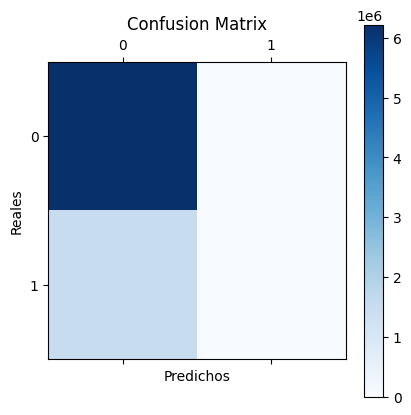

In [4]:
# Mostramos la matriz de confusión
cm = metrics_clf["confusion_matrix"]
plt.matshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predichos"); plt.ylabel("Reales")
plt.colorbar();
plt.show()

In [5]:
# Para regresión: predecir CO a partir de NO y NO2 (dataset calidad de aire)
src2 = CSVDataSource("datasets/madrid_2001_2018_calidad_aire.csv")
df_reg = cleaner.clean(src2.load()).dropna(subset=["CO","NO","NO_2"])
X_reg = df_reg[["NO","NO_2"]]
y_reg = df_reg["CO"]

reg = LinearRegressionModel().fit(X_reg, y_reg)
metrics_reg = reg.evaluate(X_reg, y_reg)
print("Regresión Metrics:", metrics_reg)

Regresión Metrics: {'mse': 0.14144590063802895, 'r2': 0.2912938313342345}


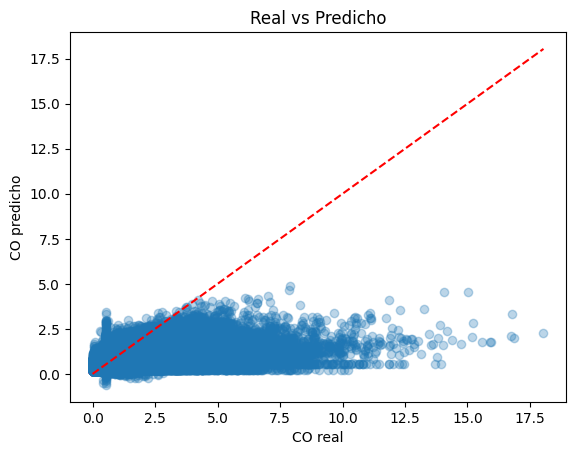

In [ ]:
# Scatter real vs predicho
y_pred = reg.predict(X_reg)
plt.scatter(y_reg, y_pred, alpha=0.3)
plt.plot([y_reg.min(),y_reg.max()],[y_reg.min(),y_reg.max()], 'r--')
plt.xlabel("CO real"); plt.ylabel("CO predicho")
plt.title("Real vs Predicho")
plt.show()


In [7]:
# Para clustering: agrupamos estaciones por media de contaminantes
df_clust = cleaner.clean(src2.load()).groupby("station")[["CO","NO","NOx"]].mean()
X_clust = df_clust  # cada fila = estación, features = medias
clust = KMeansClustering(n_clusters=4).fit(X_clust)
labels = clust.predict(X_clust)

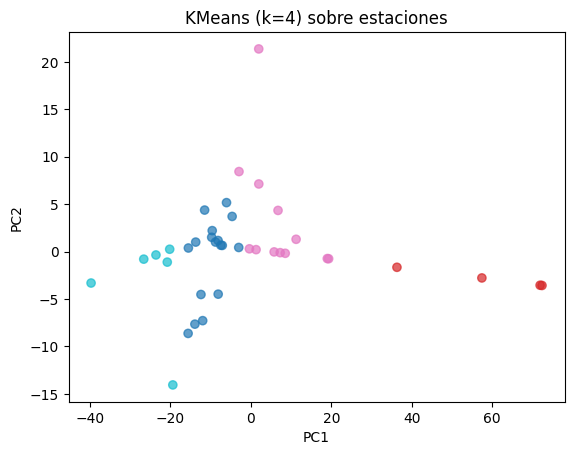

Clustering Metrics: {'inertia': 2826.92157444072, 'silhouette': np.float64(0.423798589546188)}


In [9]:
# Proyección PCA para visualizar
from sklearn.decomposition import PCA
coords = PCA(2).fit_transform(X_clust)
plt.scatter(coords[:,0], coords[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.title("KMeans (k=4) sobre estaciones"); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("Clustering Metrics:", clust.evaluate(X_clust))